In [377]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import re
import string 
import scipy

In [378]:
# Read file according to .txt format

def read_file(filename):
    file_dict = {}
    file = open(filename, 'r')
    lines = file.readlines()
    for line in lines:
        line = line.strip().split("|")
        key = line[0]
        line_dict = ast.literal_eval("{"+line[1]+"}")
        file_dict[key] = line_dict
    return(file_dict)

cluster0_dict = read_file('cluster0.txt')
tfidf_dict = read_file('tfidf.txt')

In [379]:
# Read dictionary, which has different format

def read_file2(filename):
    file_dict = {}
    file = open(filename, 'r')
    lines = file.readlines()
    for line in lines:
        line = line.split()
        file_dict[int(line[1])] = line[0]
    return(file_dict)

dictionary = read_file2('dictionary.txt')

In [380]:
# Convert data
from sklearn.preprocessing import normalize

cluster0_df = pd.DataFrame.from_dict(cluster0_dict).transpose()
cluster0_df = cluster0_df.replace(np.nan,0) 
tfidf_df = pd.DataFrame.from_dict(tfidf_dict).transpose()
tfidf_df = tfidf_df.replace(np.nan,0) 

cluster0_mat = scipy.sparse.csr_matrix(cluster0_df.values)
tfidf_mat = normalize(scipy.sparse.csr_matrix(tfidf_df.values))
# Dense array
tfidf_arr = tfidf_mat.toarray()

print(len(tfidf_df))
# We have 15902 obs
# Want avg of 10-15 obs a cluster -> n = 1060-1590
# Test some points between the two 


15902


In [381]:
# Test if code works with a small subsample of the data
#tfidf_df = tfidf_df[0:100]
#tfidf_mat = tfidf_mat[0:100]
#tfidf_arr = tfidf_arr[0:100, :]

In [382]:
# Function for cluster centers

def compute_centers(data, labels):
    n = data.shape[0]
    k = max(labels)
    sums = np.zeros((k+1, data.shape[1]))
    counts = np.zeros((k+1, data.shape[1]))
    for i in range(n):
        j = labels[i]
        sums[j] += data[i]
        counts[j] += np.ones(data.shape[1])
    centers = sums / counts
    return centers

# Function for heterogeneity

def compute_heterogeneity(data, labels, centers):
    label_centers = np.array([centers[i] for i in labels])
    distance = (data - label_centers)**2
    return np.sum(distance)

# Plot heterogeneity, adopted from HW3
def plot_heterogeneity(k_list, heterogeneity):
    plt.figure(figsize=(7,4))
    plt.plot(k_list, heterogeneity,  marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of Clustering')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    
# Plot silhouette score
def plot_score(k_list, score):
    plt.figure(figsize=(7,4))
    plt.plot(k_list, score,  marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score of Clustering')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()
    
def size_distribution(labels_list, k_list):
    stats = {'k':  k_list, 'min': [], 'max': [],
             'q5': [], 'q10': [], 'q25': [], 'q50': [], 'q75': [], 'q90': [], 'q95': []}
    for labels in labels_list:
        unique, counts = np.unique(labels, return_counts=True)
        stats['min'].append(np.min(counts))
        stats['max'].append(np.max(counts))
        stats['q5'].append(np.quantile(counts, 0.05))
        stats['q10'].append(np.quantile(counts, 0.1))
        stats['q25'].append(np.quantile(counts, 0.25))
        stats['q50'].append(np.quantile(counts, 0.5))
        stats['q75'].append(np.quantile(counts, 0.75))
        stats['q90'].append(np.quantile(counts, 0.9))
        stats['q95'].append(np.quantile(counts, 0.95))
    stats = pd.DataFrame(stats)
    return stats
    
# Plot cluster size distribution
def plot_size(counts, model_name):
    plt.figure(figsize=(7,4))
    plt.hist(counts, bins=20)
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title(model_name + ' Cluster Size Distribution')
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()

In [11]:
# For k-means, use k = 1680

from sklearn.cluster import KMeans
import time

start = time.time()
kmeans = KMeans(n_clusters=1680, init='k-means++').fit(tfidf_mat)
#kmeans = KMeans(n_clusters=10, init='k-means++').fit(tfidf_mat)
print(f'Time: {time.time() - start}')

Time: 4387.238900184631


In [ ]:
km_labels = kmeans.labels_
km_centers = kmeans.cluster_centers_

0.0351311945401143
3.8237370427349973
3.0401390905450367
      k  min  max   q5  q10  q25  q50   q75   q90   q95
0  1680    1  269  2.0  3.0  4.0  7.0  11.0  18.0  26.0
5053
44


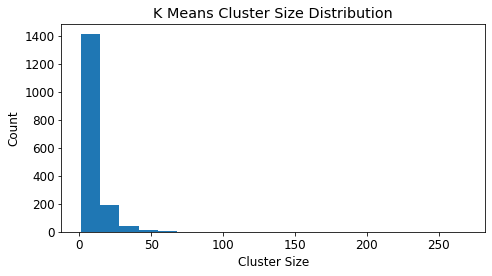

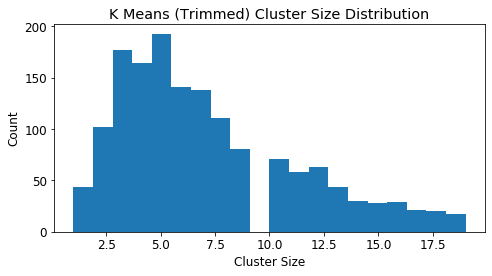

In [20]:
# Plot cluster size distribution and then distribution without outliers
from sklearn.metrics import  silhouette_score, calinski_harabasz_score, davies_bouldin_score
km_score = silhouette_score(tfidf_mat, km_labels, metric='euclidean')
print(km_score)
print(calinski_harabasz_score(tfidf_arr, km_labels))
print(davies_bouldin_score(tfidf_arr, km_labels))
print(size_distribution([km_labels], [1680]))

_, km_counts = np.unique(km_labels, return_counts=True)
plot_size(km_counts, "K Means")
km_counts_trimmed = km_counts[km_counts<20]
plot_size(km_counts_trimmed, "K Means (Trimmed)")
print(km_counts[km_counts>=20].sum())
print(km_counts[km_counts==1].sum())

In [13]:
# For hca use avg linkage and k = 1750

from sklearn.cluster import AgglomerativeClustering
import time

start = time.time()
hca = AgglomerativeClustering(n_clusters=1750, linkage="average").fit(tfidf_arr)
#hca = AgglomerativeClustering(n_clusters=10, linkage="average").fit(tfidf_arr)
print(f'Time: {time.time() - start}')

Time: 1534.5793969631195


In [ ]:
hca_labels = hca.labels_
hca_centers = compute_centers(tfidf_arr, hca_labels)

0.053602314542802454
      k  min  max   q5  q10  q25  q50  q75   q90    q95
0  1750    1  453  2.0  2.0  3.0  5.0  9.0  17.0  24.55
3.4320124693212604
2.451593918748804
6216
30


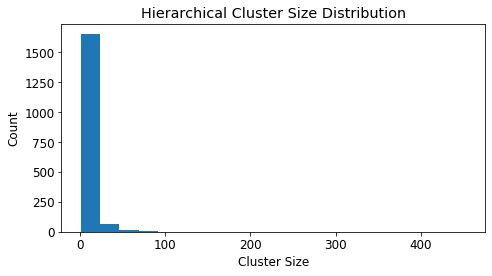

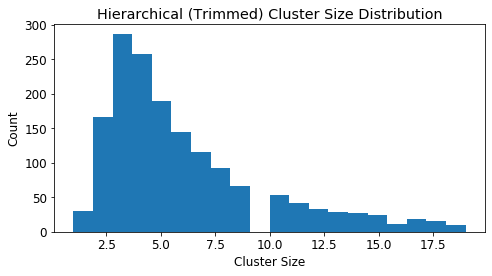

In [21]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
hca_score = silhouette_score(tfidf_arr, hca_labels, metric='euclidean')
print(hca_score)
print(size_distribution([hca_labels], [1750]))
print(calinski_harabasz_score(tfidf_arr, hca_labels))
print(davies_bouldin_score(tfidf_arr, hca_labels))

_, hca_counts = np.unique(hca_labels, return_counts=True)
plot_size(hca_counts, "Hierarchical")
hca_counts_trimmed = hca_counts[hca_counts<20]
plot_size(hca_counts_trimmed, "Hierarchical (Trimmed)")
print(hca_counts[hca_counts>=20].sum())
print(hca_counts[hca_counts==1].sum())

In [15]:
# Save models
import pickle

filename = "km_final"
with open(filename, "wb") as f:
    pickle.dump(kmeans, f)
filename = "hca_final"
with open(filename, "wb") as f:
    pickle.dump(hca, f)
#with open(filename, "rb") as f:
#    kmeans_dict=pickle.load(f)


In [383]:
# Load models

import pickle
filename = "km_final"
with open(filename, "rb") as f:
    kmeans=pickle.load(f)
    
filename = "hca_final"
with open(filename, "rb") as f:
    hca=pickle.load(f)

In [384]:
# DEC - load labels
import pickle
filename = "dec_final"
with open(filename, "rb") as f:
    dec_labels=pickle.load(f)
print(dec_labels)

tensor([ 367,  102,  177,  ..., 1089,  688, 1179])


In [ ]:
dec_centers = compute_centers(tfidf_arr, dec_labels)
dec_score = silhouette_score(tfidf_arr, dec_labels, metric='euclidean')

-0.05679904727912737
1.0909284378652786
4.888622292963917
      k  min  max   q5  q10  q25   q50   q75   q90   q95
0  1750    1   54  3.0  4.0  7.0  10.0  13.0  16.0  18.0
930
42


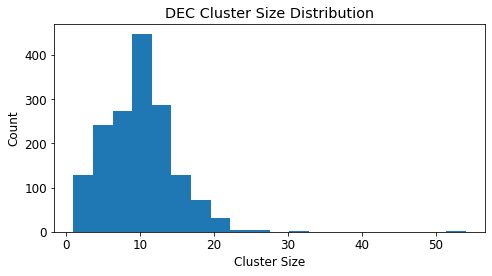

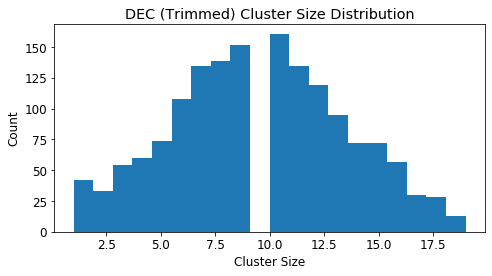

In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
print(dec_score)
print(calinski_harabasz_score(tfidf_arr, dec_labels))
print(davies_bouldin_score(tfidf_arr, dec_labels))
print(size_distribution([dec_labels], [1750]))

_, dec_counts = np.unique(dec_labels, return_counts=True)
plot_size(dec_counts, "DEC")
dec_counts_trimmed = dec_counts[dec_counts<20]
plot_size(dec_counts_trimmed, "DEC (Trimmed)")
print(dec_counts[dec_counts>=20].sum())
print(dec_counts[dec_counts==1].sum())


In [385]:
# Recommender function
# Input: index
# For cluster methods, locates cluster item is in
# For content-based, finds closest by cosine_similarity
# type is km, hca, dec, cs

# Use for final model evaluation

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import r_regression

def recommend(index, dictionary, n_words, method, df, array,  labels=None, n_articles=10):
    article_name = df.index.values[index]
    print("Recommending articles similar to:", article_name)
    highest_tfidf(index, df, dictionary, n_words)
    print('=' * 90)
    
    if method == 'cs':
        similarities = cosine_similarity(tfidf_arr[index].reshape(1, -1), tfidf_arr)
        sorted_indices = (-similarities).argsort().flatten()[1:(n_articles+1)]
    else:
        # Get indices of articles in the same clusters
        article = array[index]
        article = article.reshape(1, article.shape[0])
        cluster = labels[index]
        indices = np.argwhere(labels==cluster)
        indices = indices.reshape(indices.shape[0])
        recommended = tfidf_arr[indices]
        # Sort by euclidean distance 
        distances = euclidean_distances(article, recommended)
        #distance_indices = distances.argsort()[0][1:min(n_articles+1, len(indices))]
        distance_indices = distances.argsort()[0][1:]
        sorted_indices = indices[distance_indices]

    recommended = df.iloc[sorted_indices,:]
    recommended_names = recommended.index.values
    for i in range(len(recommended)):
        print(i+1, '. ', recommended_names[i], sep='')
        highest_tfidf(sorted_indices[i], df, dictionary, n_words)
        print('=' * 90)
    if method in ('km', 'hca', 'dec'):
        print("Note: Full cluster size is", len(indices))

# Print words with highest tf-idf
def highest_tfidf(index, df, dictionary, n):
    tfidf = df.iloc[index]
    largest = tfidf.nlargest(n)
    codes = largest.index.values
    words_tfidf = ''
    for i in range(len(largest)):
        words_tfidf = words_tfidf +  dictionary[codes[i]] + ': ' + str(round(largest.iloc[i], 2)) + ', '
    print(words_tfidf[:-2])
                                        

In [398]:
index = 0
n_words = 6

In [399]:
recommend(index, dictionary, n_words, 'km', tfidf_df, tfidf_arr, km_labels)

Recommending articles similar to: ronnyreich
reich: 6.15, discoveries: 2.71, studied: 2.23, mount: 1.94, ramat: 1.87, snyder: 1.7
1. corpusinscriptionumlatinarum
inscriptions: 5.61, inscription: 2.25, original: 1.2, published: 1.0, indices: 0.99, continues: 0.96
2. magnusolsen
inscriptions: 5.61, olsen: 5.33, scholars: 2.07, icelandic: 1.61, interpreting: 1.56, falcon: 1.46
3. masonhammond
harvards: 7.19, greek: 3.68, inscriptions: 2.81, mason: 2.57, monarchy: 2.5, contributing: 2.38
4. filossenoluzzatto
inscriptions: 5.61, philological: 3.86, deciphered: 3.74, mastered: 3.34, premature: 3.15, happening: 2.81
5. amorgos
ancient: 3.35, tombs: 2.0, inscriptions: 1.87, situated: 1.24, ionian: 1.16, richter: 1.1
6. hargsbrorunicinscriptions
inscriptions: 5.61, bro: 4.73, inscription: 4.19, strongman: 1.58, peculiarity: 1.55, sons: 1.37
7. lacunamanuscripts
weathered: 7.88, nouns: 7.11, grams: 7.04, textual: 6.58, inscriptions: 5.61, interpretations: 5.55
8. reitia
offerings: 5.48, este: 3.

In [400]:
recommend(index, dictionary, n_words, 'hca', tfidf_df, tfidf_arr, hca_labels)

Recommending articles similar to: ronnyreich
reich: 6.15, discoveries: 2.71, studied: 2.23, mount: 1.94, ramat: 1.87, snyder: 1.7
1. ottoweidinger
reich: 6.15, dachau: 4.73, battalion: 3.79, unit: 2.57, division: 2.19, command: 2.0
2. nsdapao
reich: 2.63, party: 2.63, paraguay: 1.77, comrades: 1.69, abroad: 1.19, betterment: 1.08
3. hanserichvoss
bunker: 6.34, reich: 6.15, joseph: 3.52, suicide: 2.96, wounded: 2.73, accompanied: 2.61
4. walterkrgerssofficer
latvian: 3.64, wehrmacht: 3.48, command: 3.34, reich: 3.07, division: 2.74, voluntary: 2.49
5. fichtebunker
bunker: 5.07, berlins: 4.37, cupola: 2.88, building: 2.4, residences: 2.21, lighting: 2.01
6. dora1
bunker: 6.34, todt: 3.94, thick: 2.29, organisation: 2.05, tugboats: 1.97, wall: 1.8
Note: Full cluster size is 7


In [401]:
recommend(index, dictionary, n_words, 'dec', tfidf_df, tfidf_arr, dec_labels.numpy())

Recommending articles similar to: ronnyreich
reich: 6.15, discoveries: 2.71, studied: 2.23, mount: 1.94, ramat: 1.87, snyder: 1.7
1. sonning
club: 2.62, rfc: 2.33, holme: 1.93, railway: 1.72, passengers: 1.64, house: 1.31
2. costperengagement
engagement: 4.63, advertisers: 3.39, advertiser: 2.79, ads: 2.77, engages: 2.52, cpa: 2.42
3. ranideldeocampo
fourtime: 7.28, assists: 5.26, possesses: 5.26, assembled: 4.73, impact: 3.65, seasons: 3.46
4. sashamitchell
mitchell: 5.02, mitchells: 3.64, musketeers: 1.29, appearances: 1.2, garment: 1.08, weber: 0.99
5. thebangersisters
lavinia: 7.73, vinnie: 5.26, daughters: 2.68, gogo: 2.58, retrieves: 2.49, neurotic: 2.46
6. pasargadbank
tehran: 4.73, currently: 2.28, largest: 2.01, conglomerate: 1.56, bankers: 1.56, group: 1.41
7. tarheelsportsnetwork
basketball: 4.01, charlotte: 2.44, longtime: 1.53, station: 1.31, affiliates: 0.99, airs: 0.95
8. danieljanzen
habitat: 4.74, pastures: 4.39, integrate: 3.82, puerto: 3.33, biology: 3.31, natural: 2

In [402]:
recommend(index, dictionary, n_words, 'cs', tfidf_df, tfidf_arr)

Recommending articles similar to: ronnyreich
reich: 6.15, discoveries: 2.71, studied: 2.23, mount: 1.94, ramat: 1.87, snyder: 1.7
1. ottoweidinger
reich: 6.15, dachau: 4.73, battalion: 3.79, unit: 2.57, division: 2.19, command: 2.0
2. nsdapao
reich: 2.63, party: 2.63, paraguay: 1.77, comrades: 1.69, abroad: 1.19, betterment: 1.08
3. hanserichvoss
bunker: 6.34, reich: 6.15, joseph: 3.52, suicide: 2.96, wounded: 2.73, accompanied: 2.61
4. walterkrgerssofficer
latvian: 3.64, wehrmacht: 3.48, command: 3.34, reich: 3.07, division: 2.74, voluntary: 2.49
5. saulfriedlnder
antisemitism: 6.73, jews: 4.54, normal: 3.6, reich: 3.07, sees: 2.15, argued: 1.99
6. ahnenerbe
expedition: 4.43, walther: 2.46, ancient: 2.45, artifacts: 2.4, reich: 1.64, hans: 1.64
7. morizvonkuffner
von: 4.07, ignaz: 3.64, mont: 3.36, austrian: 2.38, austria: 2.14, reich: 2.05
8. pfennig
euro: 4.0, unicode: 3.69, silver: 3.62, coating: 3.15, reich: 3.07, penny: 3.06
9. 554calibermark42gun
mount: 3.88, barrel: 1.21, fires